In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import gymnasium as gym
env = gym.make('CartPole-v1')

In [ ]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

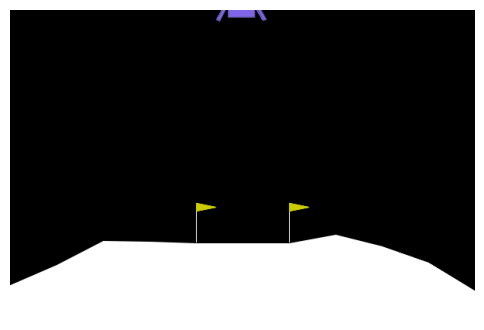

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Create environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")
obs, _ = env.reset()

frames = []
done = False

# Collect frames
while not done:
    frame = env.render()
    frames.append(frame)
    obs, reward, terminated, truncated, _ = env.step(env.action_space.sample())
    done = terminated or truncated

env.close()

# Create figure for animation
fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    img.set_data(frames[i])
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=40)
HTML(anim.to_jshtml())


In [ ]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [ ]:
learning_rate = 0.003
n_episodes = 1000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [ ]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [02:48<00:00, 5946.28it/s]


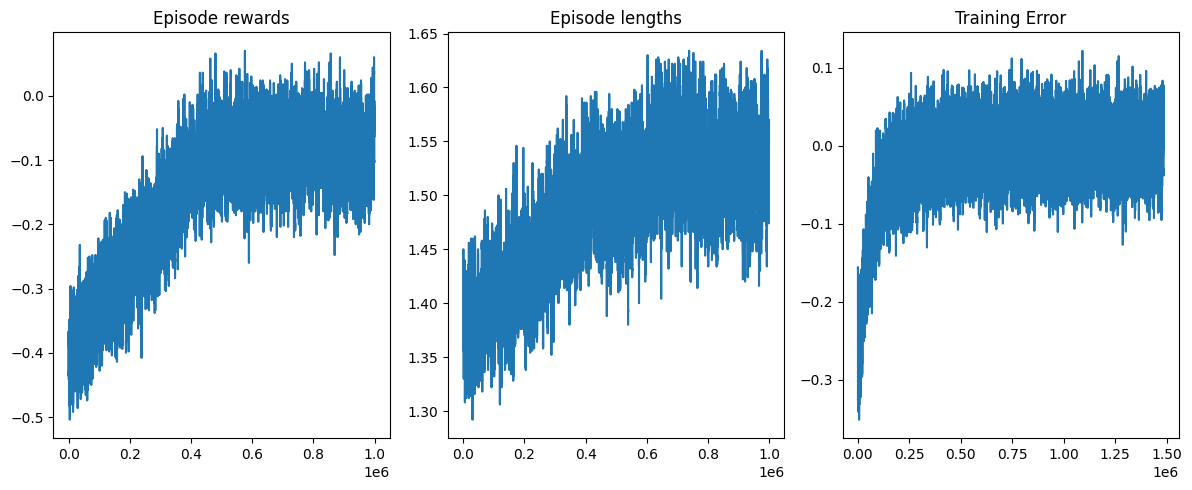

In [ ]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent_SARSA:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        next_action = self.get_action(next_obs)
        """Updates the Q-value of an action."""
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * (reward + self.discount_factor * self.q_values[next_obs][next_action] - self.q_values[obs][action])
        )
        self.training_error.append(reward + self.discount_factor * self.q_values[next_obs][next_action] - self.q_values[obs][action])

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [ ]:
learning_rate = 0.003
n_episodes = 1000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env_SARSA = gym.make("Blackjack-v1", sab=False)
env_SARSA = gym.wrappers.RecordEpisodeStatistics(env_SARSA, buffer_length=n_episodes)

agent_SARSA = BlackjackAgent_SARSA(
    env=env_SARSA,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env_SARSA.reset()
    done = False

    # play one episode
    while not done:
        action = agent_SARSA.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_SARSA.step(action)

        # update the agent
        agent_SARSA.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent_SARSA.decay_epsilon()

100%|██████████| 1000000/1000000 [02:48<00:00, 5942.61it/s]


In [ ]:
print(len(env_SARSA.return_queue))
print(len(env.return_queue))


1000000
1000000


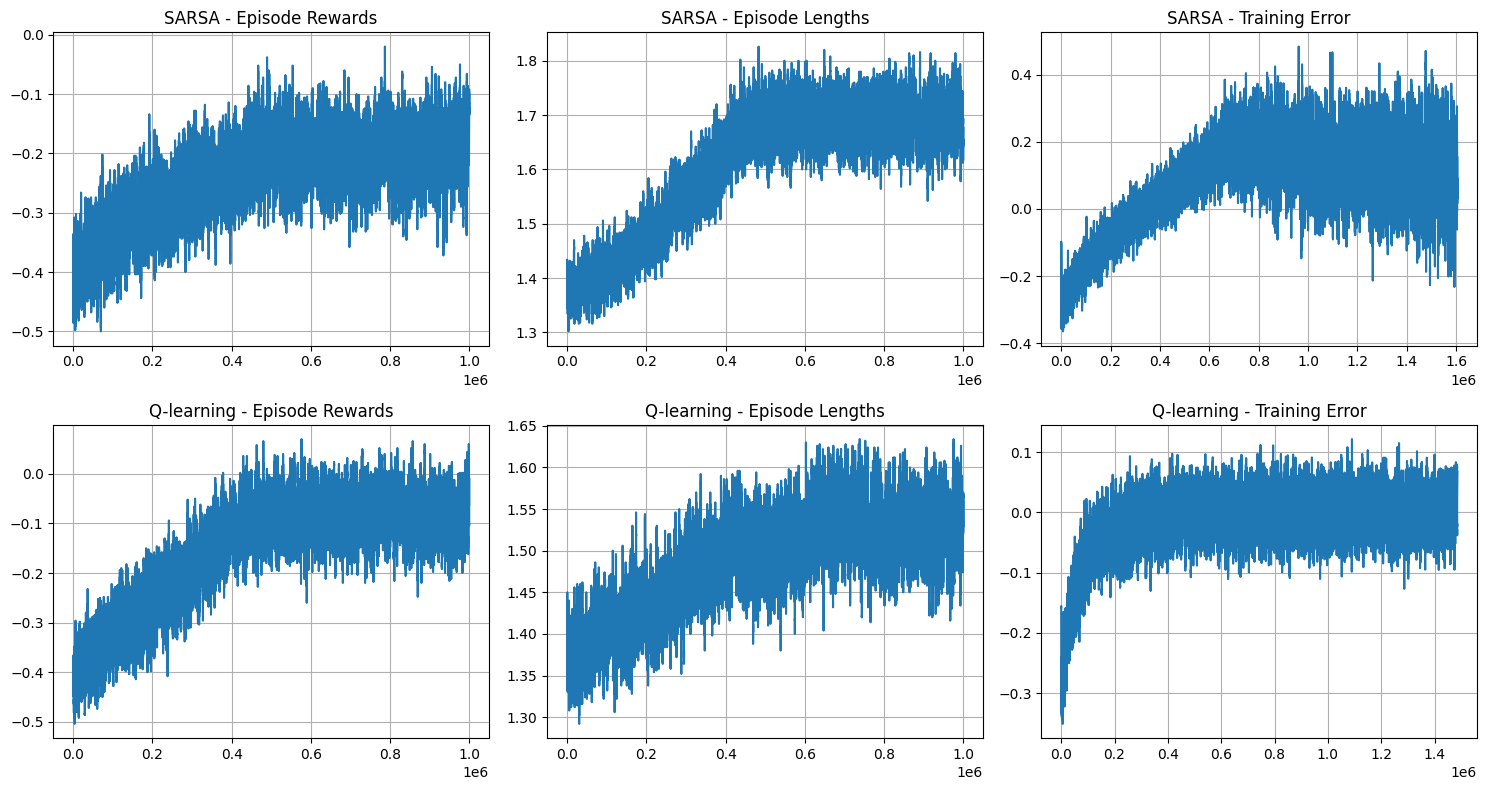

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

rolling_length = 500
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# --- SARSA ---
axs[0][0].set_title("SARSA - Episode Rewards")
reward_moving_avg_sarsa = get_moving_avgs(env_SARSA.return_queue, rolling_length, "valid")
axs[0][0].plot(range(len(reward_moving_avg_sarsa)), reward_moving_avg_sarsa)

axs[0][1].set_title("SARSA - Episode Lengths")
length_moving_avg_sarsa = get_moving_avgs(env_SARSA.length_queue, rolling_length, "valid")
axs[0][1].plot(range(len(length_moving_avg_sarsa)), length_moving_avg_sarsa)

axs[0][2].set_title("SARSA - Training Error")
error_moving_avg_sarsa = get_moving_avgs(agent_SARSA.training_error, rolling_length, "same")
axs[0][2].plot(range(len(error_moving_avg_sarsa)), error_moving_avg_sarsa)

# --- Q-learning ---
axs[1][0].set_title("Q-learning - Episode Rewards")
reward_moving_avg_q = get_moving_avgs(env.return_queue, rolling_length, "valid")
axs[1][0].plot(range(len(reward_moving_avg_q)), reward_moving_avg_q)

axs[1][1].set_title("Q-learning - Episode Lengths")
length_moving_avg_q = get_moving_avgs(env.length_queue, rolling_length, "valid")
axs[1][1].plot(range(len(length_moving_avg_q)), length_moving_avg_q)

axs[1][2].set_title("Q-learning - Training Error")
error_moving_avg_q = get_moving_avgs(agent.training_error, rolling_length, "same")
axs[1][2].plot(range(len(error_moving_avg_q)), error_moving_avg_q)

# Styling
for ax in axs.flat:
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

returns = np.array(env_SARSA.return_queue)

# Basic stats
print("SARSA Agent Performance Summary:")
print(f"Total episodes:       {len(returns)}")
print(f"Average return:       {np.mean(returns):.4f}")
print(f"Median return:        {np.median(returns):.4f}")
print(f"Standard deviation:   {np.std(returns):.4f}")
print(f"Max return:           {np.max(returns)}")
print(f"Min return:           {np.min(returns)}")

# Optional: success rate (assuming win = 1.0 reward)
print(f"Winning rate:         {np.mean(returns == 1.0):.4f}")
print(f"Losing rate:          {np.mean(returns == -1.0):.4f}")
print(f"Tie rate:             {np.mean(returns == 0.0):.4f}")


SARSA Agent Performance Summary:
Total episodes:       1000000
Average return:       -0.2403
Median return:        -1.0000
Standard deviation:   0.9335
Max return:           1.0
Min return:           -1.0
Winning rate:         0.3445
Losing rate:          0.5848
Tie rate:             0.0708


In [ ]:
import numpy as np

returns = np.array(env.return_queue)

# Basic stats
print("Q-Learning Agent Performance Summary:")
print(f"Total episodes:       {len(returns)}")
print(f"Average return:       {np.mean(returns):.4f}")
print(f"Median return:        {np.median(returns):.4f}")
print(f"Standard deviation:   {np.std(returns):.4f}")
print(f"Max return:           {np.max(returns)}")
print(f"Min return:           {np.min(returns)}")

# Optional: success rate (assuming win = 1.0 reward)
print(f"Winning rate:         {np.mean(returns == 1.0):.4f}")
print(f"Losing rate:          {np.mean(returns == -1.0):.4f}")
print(f"Tie rate:             {np.mean(returns == 0.0):.4f}")


Q-Learning Agent Performance Summary:
Total episodes:       1000000
Average return:       -0.1565
Median return:        -1.0000
Standard deviation:   0.9480
Max return:           1.0
Min return:           -1.0
Winning rate:         0.3834
Losing rate:          0.5398
Tie rate:             0.0768
